# 1. Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath(".."))
from utils import DataFetcher, DataPreparation, Visualization, find_similar_phrases, StreetNormalizer, load_mappings, map_vehicle_type

# 2. Data load

## 2.1 DataFrame creation

In [2]:
# Path variables
csv_path = "../data/nypd-motor-vehicle-collisions.csv"
config_file = "../config/config.json"

In [3]:
df = DataFetcher.get_data(csv_path, config_file)

## 2.2 Brief summary

In [4]:
df.dtypes

BOROUGH                          string[python]
LATITUDE                                float32
LONGITUDE                               float32
ON STREET NAME                   string[python]
CROSS STREET NAME                string[python]
OFF STREET NAME                  string[python]
NUMBER OF PERSONS INJURED                 Int16
NUMBER OF PERSONS KILLED                  Int16
CONTRIBUTING FACTOR VEHICLE 1    string[python]
CONTRIBUTING FACTOR VEHICLE 2    string[python]
CONTRIBUTING FACTOR VEHICLE 3    string[python]
CONTRIBUTING FACTOR VEHICLE 4    string[python]
CONTRIBUTING FACTOR VEHICLE 5    string[python]
COLLISION_ID                     string[python]
VEHICLE TYPE CODE 1              string[python]
VEHICLE TYPE CODE 2              string[python]
VEHICLE TYPE CODE 3              string[python]
VEHICLE TYPE CODE 4              string[python]
VEHICLE TYPE CODE 5              string[python]
dtype: object

In [5]:
summary = DataFetcher.show_null_values_summary(df)
print(summary)

COLLISION_ID                           0
NUMBER OF PERSONS INJURED             17
NUMBER OF PERSONS KILLED              33
CONTRIBUTING FACTOR VEHICLE 1       4324
VEHICLE TYPE CODE 1                 5581
LATITUDE                          196285
LONGITUDE                         196285
CONTRIBUTING FACTOR VEHICLE 2     216051
VEHICLE TYPE CODE 2               265320
ON STREET NAME                    314176
BOROUGH                           484625
CROSS STREET NAME                 532985
OFF STREET NAME                  1392446
VEHICLE TYPE CODE 3              1483436
CONTRIBUTING FACTOR VEHICLE 3    1507924
VEHICLE TYPE CODE 4              1566169
CONTRIBUTING FACTOR VEHICLE 4    1590389
VEHICLE TYPE CODE 5              1602028
CONTRIBUTING FACTOR VEHICLE 5    1606556
dtype: int64


# 3. Dataset information

In [6]:
df.shape

(1612178, 19)

In [7]:
df.columns

Index(['BOROUGH', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME',
       'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [8]:
df.head()

,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,QUEENS,40.676052,-73.790184,<NA>,<NA>,150-08 123 AVENUE,0,0,Passing Too Closely,Unspecified,<NA>,<NA>,<NA>,4184637,Sedan,Pick-up Truck,<NA>,<NA>,<NA>
1,BROOKLYN,40.657780,-73.951096,<NA>,<NA>,288 HAWTHORNE STREET,0,0,Passing Too Closely,Unspecified,<NA>,<NA>,<NA>,4195773,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,<NA>,<NA>,<NA>
2,MANHATTAN,40.718143,-73.993835,CHRYSTIE STREET,GRAND STREET,<NA>,1,0,Driver Inattention/Distraction,<NA>,<NA>,<NA>,<NA>,4202457,Sedan,<NA>,<NA>,<NA>,<NA>
3,BRONX,40.840534,-73.866608,<NA>,<NA>,1837 EAST TREMONT AVENUE,0,0,Unspecified,Unspecified,<NA>,<NA>,<NA>,4198749,Taxi,Station Wagon/Sport Utility Vehicle,<NA>,<NA>,<NA>
4,MANHATTAN,40.745441,-73.975403,EAST 35 STREET,2 AVENUE,<NA>,1,0,Driver Inattention/Distraction,Driver Inattention/Distraction,<NA>,<NA>,<NA>,4183798,Station Wagon/Sport Utility Vehicle,Bike,<NA>,<NA>,<NA>


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612178 entries, 0 to 1612177
Data columns (total 19 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   BOROUGH                        1127553 non-null  string 
 1   LATITUDE                       1415893 non-null  float32
 2   LONGITUDE                      1415893 non-null  float32
 3   ON STREET NAME                 1298002 non-null  string 
 4   CROSS STREET NAME              1079193 non-null  string 
 5   OFF STREET NAME                219732 non-null   string 
 6   NUMBER OF PERSONS INJURED      1612161 non-null  Int16  
 7   NUMBER OF PERSONS KILLED       1612145 non-null  Int16  
 8   CONTRIBUTING FACTOR VEHICLE 1  1607854 non-null  string 
 9   CONTRIBUTING FACTOR VEHICLE 2  1396127 non-null  string 
 10  CONTRIBUTING FACTOR VEHICLE 3  104254 non-null   string 
 11  CONTRIBUTING FACTOR VEHICLE 4  21789 non-null    string 
 12  CONTRIBUTING F

In [10]:
df.describe()

,LATITUDE,LONGITUDE,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED
count,1.415893e+06,1.415893e+06,1612161.0,1612145.0
mean,4.068864e+01,-7.386655e+01,0.263136,0.001186
std,1.200403e+00,2.438640e+00,0.658483,0.036449
min,0.000000e+00,-2.012371e+02,0.0,0.0
25%,4.066882e+01,-7.397746e+01,0.0,0.0
50%,4.072258e+01,-7.393002e+01,0.0,0.0
75%,4.076789e+01,-7.386727e+01,0.0,0.0
max,4.231832e+01,0.000000e+00,31.0,8.0


In [11]:
duples = df.duplicated().sum()
print(f"Given dataset has {duples} duplicates")

Given dataset has 394221 duplicates


# 4. Data Cleaning

## 4.1. DataPreparation class init

In [12]:
preparation = DataPreparation(df)

## 4.2. Column standarization

In [13]:
text_cols = ['ON STREET NAME','CROSS STREET NAME', 'OFF STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1',
             'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4',
             'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
             'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
number_cols =['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED']

In [14]:
preparation.standarize_text(text_cols)

In [15]:
preparation.standarize_numbers(number_cols)

## 4.3. Boroughs

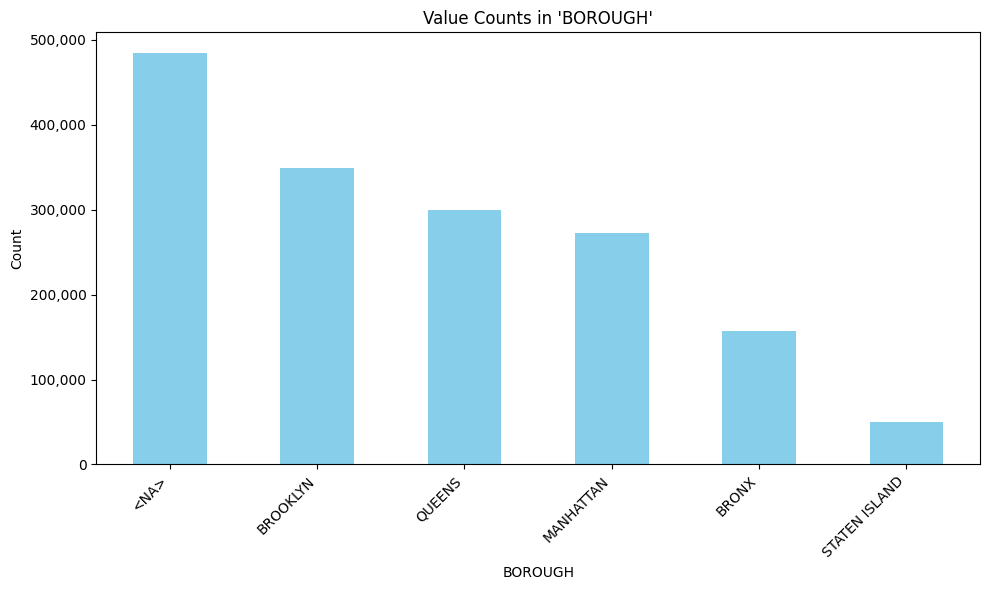

In [16]:
# Unique values in BOROUGH column
Visualization.show_unique_observations(preparation.df, "BOROUGH")

In [17]:
preparation.count_missing_boroughs()

Missing boroughs: 30.06%


### 4.3.1 Filling missing boroughs from shapefile

In [18]:
preparation.fill_missing_boroughs()

In [19]:
preparation.standarize_text(["BOROUGH"])

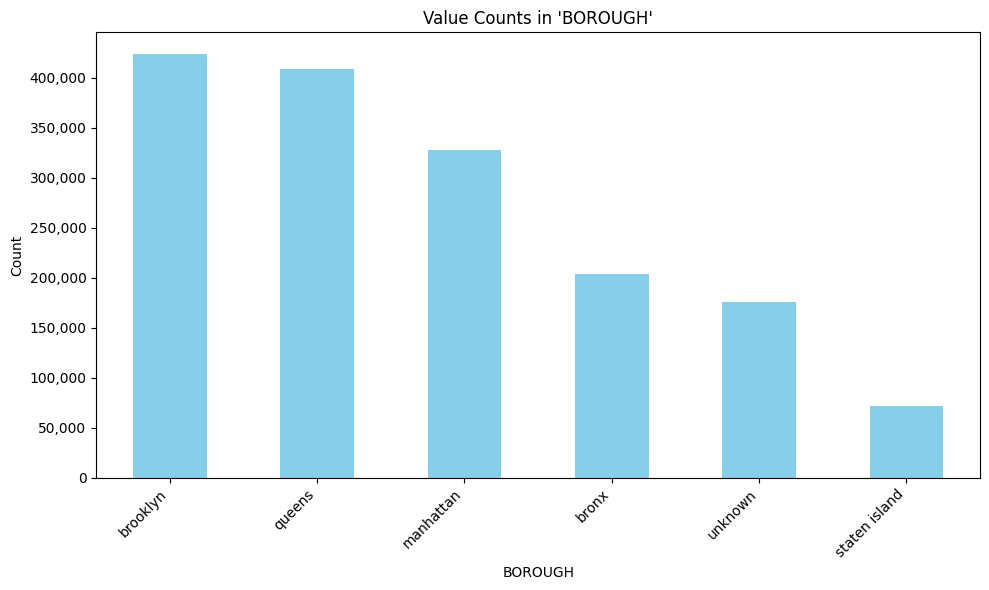

In [20]:
# Unique values in BOROUGH column
Visualization.show_unique_observations(preparation.df, "BOROUGH")

In [21]:
preparation.count_missing_boroughs()

Missing boroughs: 0.0%


## 4.4 Latitude and longitude

In [22]:
cols_to_fill = ["LATITUDE","LONGITUDE"]
preparation.df[cols_to_fill] = preparation.df[cols_to_fill].apply(lambda col: col.fillna("unknown"))

## 4.5 Number of persons

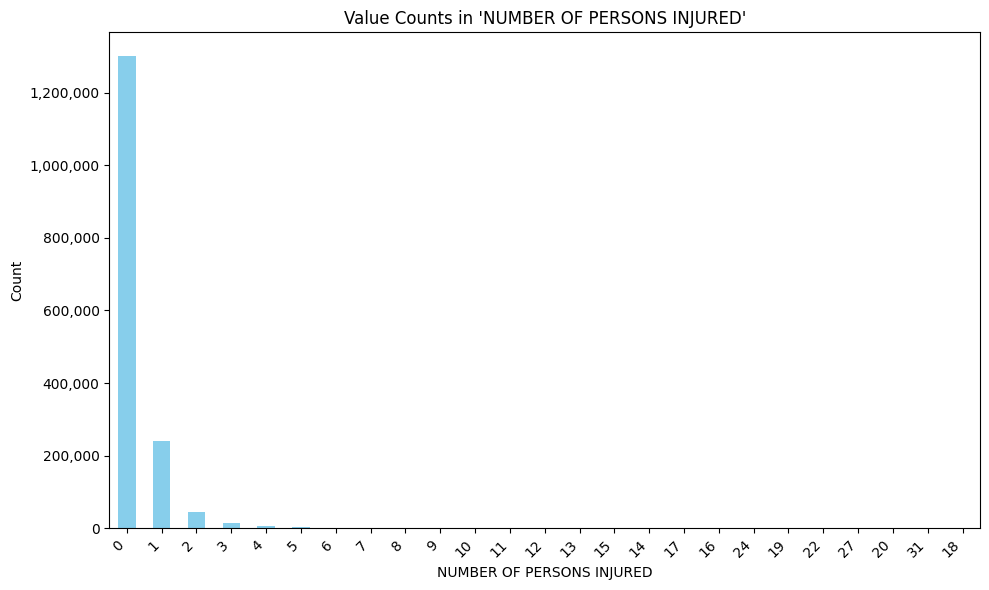

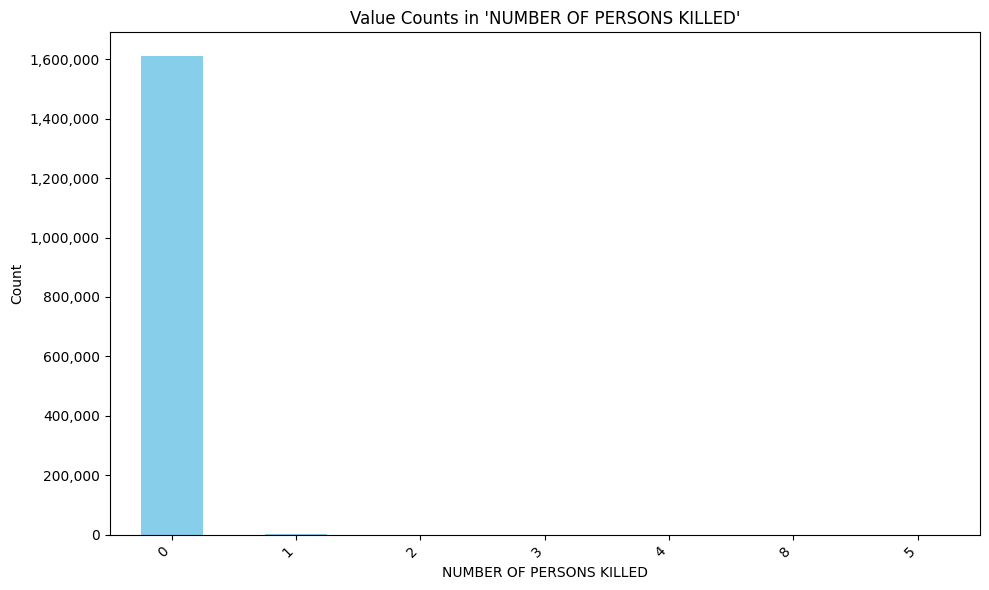

In [25]:
Visualization.show_unique_observations(preparation.df, "NUMBER OF PERSONS INJURED")
Visualization.show_unique_observations(preparation.df, "NUMBER OF PERSONS KILLED")

## 4.6 Streets

In [26]:
streets_to_format = ["ON STREET NAME", "CROSS STREET NAME", "OFF STREET NAME"]

In [27]:
# Normalization of common street abbreviations
normalizer = StreetNormalizer()
preparation.df = normalizer.normalize_df_cols(preparation.df, streets_to_format)

## 4.7 Contributing factors

In [28]:
cfv_typos_cols_1 = find_similar_phrases(preparation.df["CONTRIBUTING FACTOR VEHICLE 1"])
cfv_typos_cols_2 = find_similar_phrases(preparation.df["CONTRIBUTING FACTOR VEHICLE 2"])
cfv_typos_cols_3 = find_similar_phrases(preparation.df["CONTRIBUTING FACTOR VEHICLE 3"])
cfv_typos_cols_4 = find_similar_phrases(preparation.df["CONTRIBUTING FACTOR VEHICLE 4"])
cfv_typos_cols_5 = find_similar_phrases(preparation.df["CONTRIBUTING FACTOR VEHICLE 5"])

In [29]:
print(f"CFV 1 typos {cfv_typos_cols_1}")
print(f"CFV 2 typos {cfv_typos_cols_2}")
print(f"CFV 3 typos {cfv_typos_cols_3}")
print(f"CFV 4 typos {cfv_typos_cols_4}")
print(f"CFV 5 typos {cfv_typos_cols_5}")

CFV 1 typos {'reaction to uninvolved vehicle': ['reaction to other uninvolved vehicle'], 'illnes': ['illness'], 'reaction to other uninvolved vehicle': ['reaction to uninvolved vehicle'], 'illness': ['illnes']}
CFV 2 typos {'reaction to uninvolved vehicle': ['reaction to other uninvolved vehicle'], 'illnes': ['illness'], 'reaction to other uninvolved vehicle': ['reaction to uninvolved vehicle'], 'illness': ['illnes']}
CFV 3 typos {'reaction to uninvolved vehicle': ['reaction to other uninvolved vehicle'], 'illnes': ['illness'], 'illness': ['illnes'], 'reaction to other uninvolved vehicle': ['reaction to uninvolved vehicle']}
CFV 4 typos {}
CFV 5 typos {}


### 4.7.1 Corrections directory

In [30]:
corrections_cfv = {"reaction to other uninvolved vehicle":"reaction to uninvolved vehicle", "illnes":"illness", "nan":"unknown", 
                  "80": "unknown", "1": "unknown"}

### 4.7.2 Typo corrections

In [31]:
cfv_cols_to_correct = ["CONTRIBUTING FACTOR VEHICLE 1", "CONTRIBUTING FACTOR VEHICLE 2", "CONTRIBUTING FACTOR VEHICLE 3",
                     "CONTRIBUTING FACTOR VEHICLE 4", "CONTRIBUTING FACTOR VEHICLE 5"]
preparation.df[cfv_cols_to_correct] = preparation.df[cfv_cols_to_correct].replace(corrections_cfv)

In [32]:
cfv_typos_cols_1_cleaned = find_similar_phrases(preparation.df["CONTRIBUTING FACTOR VEHICLE 1"])
print(cfv_typos_cols_1_cleaned)

{}


## 4.8 Vehicle types

### 4.8.1 Similar words overview

In [33]:
vtc1 = find_similar_phrases(preparation.df["VEHICLE TYPE CODE 1"], 80)

In [34]:
#for key, values in vtc1.items():
#    print(f"{key}: {", ".join(values)}")

In [35]:
type_cols_to_correct = ["VEHICLE TYPE CODE 1", "VEHICLE TYPE CODE 2", "VEHICLE TYPE CODE 3", "VEHICLE TYPE CODE 4", "VEHICLE TYPE CODE 5"]

### 4.8.2 Load mappings from JSON file

In [36]:
raw_mapping, generalized_mapping = load_mappings()

In [37]:
print("Raw Mapping:", raw_mapping is not None)
print("Generalized Mapping:", generalized_mapping is not None)

Raw Mapping: True
Generalized Mapping: True


### 4.8.3 Map vehicle types

In [38]:
preparation.df = map_vehicle_type(
    preparation.df,
    type_cols_to_correct,
    generalized=True,
    raw_mapping=raw_mapping,
    generalized_mapping=generalized_mapping
)

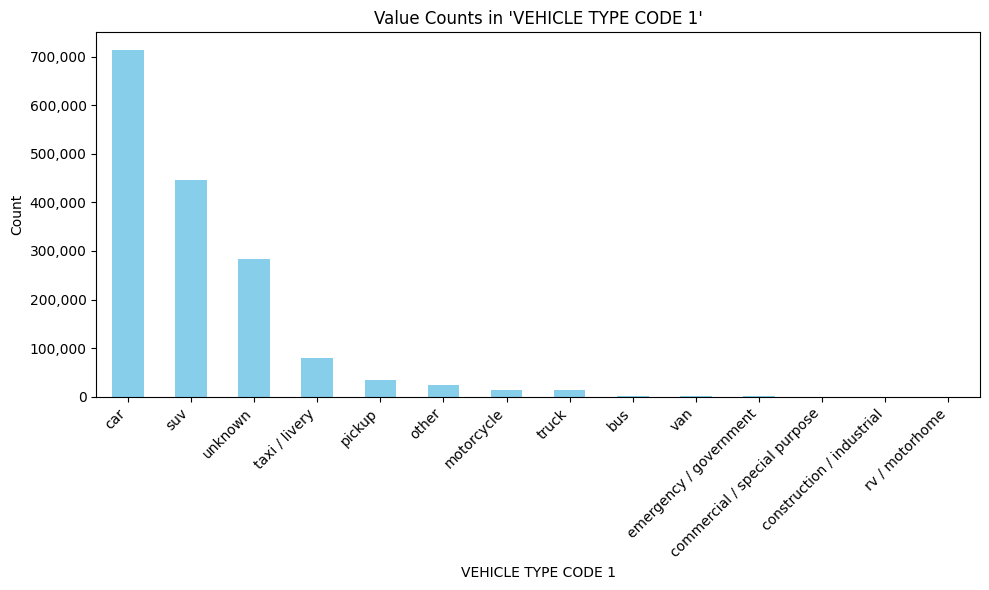

In [39]:
Visualization.show_unique_observations(preparation.df, "VEHICLE TYPE CODE 1")

In [40]:
def check_dict(list, dict):
    not_included = []
    for i in list: 
        if not i in (dict):
            not_included.append(i)
    return not_included

In [41]:
print(check_dict(preparation.df["VEHICLE TYPE CODE 1"].unique(), generalized_mapping))

[]


## 4.9 Duplicates

In [43]:
preparation.df.duplicated().sum()

np.int64(394221)

In [44]:
preparation.clean_data()

In [46]:
preparation.df.duplicated().sum()

np.int64(0)

# 5. Export data

In [47]:
preparation.save_data("../data/nypd-motor-vehicle-collisions-cleaned.csv")